In [1]:
import glob 
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F  # activation function
from torch.distributions import Laplace, Normal
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from datetime import datetime

import poisevae
from poisevae.datasets import MNIST_GM
from poisevae.networks.MNISTGMNetworks import EncMNIST, DecMNIST, EncGM, DecGM

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')

joint_dataset_train = MNIST_GM(mnist_pt_path=MNIST_PATH % 'train', data_augment=1, radius=1)
joint_dataset_test = MNIST_GM(mnist_pt_path=MNIST_PATH % 'test', data_augment=1, radius=1)

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(187, 31)

In [6]:
lat1, lat2 = 2, 2
emb_dim = 8
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_gm = EncGM(2, emb_dim, lat2).to(device)
dec_gm = DecGM(2, emb_dim, lat2).to(device)

vae = poisevae.POISEVAE([enc_mnist, enc_gm], [dec_mnist, dec_gm], likelihoods=[Laplace, Normal], 
                        latent_dims=[lat1, lat2], fix_t=False, batch_size=batch_size).to(device)

In [7]:
# for i in vae.named_parameters():
#     print(i[0])

In [8]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3, amsgrad=True)

In [9]:
PATH = os.path.join('runs/MNIST_GM', datetime.now().strftime('%y%m%d%H%M'))

In [10]:
epoch = 0
# try:
#     vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [11]:
# writer = SummaryWriter(PATH)
writer = None

In [ ]:
epochs = 40 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, writer)
    poisevae.utils.test(vae, test_loader, epoch, writer)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1) 

In [15]:
# writer.flush()
# writer.close()

In [16]:
# poisevae.utils.save_latent_info(latent_info, PATH)

In [10]:
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob('runs/MNIST_GM/rad4_4/' + 'train*.pt'))[-1])
epoch

40

In [45]:
joint_dataset_test = MNIST_GM(mnist_pt_path=MNIST_PATH % 'test', data_augment=1, radius=4)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=400, shuffle=True, drop_last=True)
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
        break

In [46]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([400, 2]), torch.Size([400, 2]))

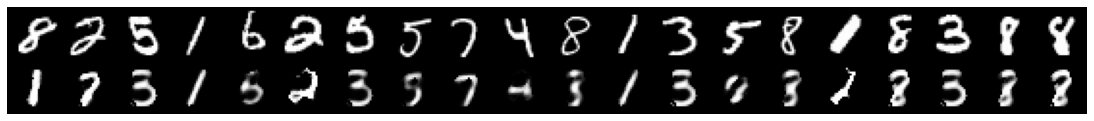

In [47]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_axis_off()
# ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

In [48]:
# ncols = min(len(x_rec[0]), 20)
# nrows = 2 * int(np.floor(len(x_rec[0]) / 20))
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
# for i, aux in enumerate(zip(data[0], x_rec[0])):
#     if i >= nrows / 2 * 20:
#         break
#     for j, im in enumerate(aux):
#         ax[j+i//20*2, i%20].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
#         ax[j+i//20*2, i%20].set_xticks([])
#         ax[j+i//20*2, i%20].set_yticks([])
#     ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
# fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRecExtra.pdf', dpi=300)

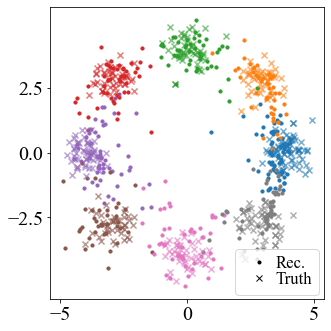

In [49]:
fig, ax = plt.subplots(1, figsize=(5, 5))
for i in range(0, 8):
    ax.scatter(*x_rec[1][data[-1]==i+1].detach().cpu().numpy().T, c='C%d'%i, s=10, zorder=2)
    ax.scatter(*data[1][data[-1]==i+1].detach().cpu().numpy().T, c='C%d'%i, alpha=0.6, marker='x', zorder=3)
ax.set_yticks([-2.5, 0, 2.5])
ax.plot([], [], marker='.', c='k', alpha=1, label='Rec.', linewidth=0)
ax.plot([], [], marker='x', c='k', alpha=1, label='Truth', linewidth=0)
fig.legend(fontsize='small', loc=(0.71, 0.11), ncol=1, handletextpad=0, labelspacing=0)
fig.tight_layout()
# fig.savefig(PATH + 'GMRec.pdf', dpi=300)